
# Week 5 - Discovering Patterns: Clusters & Topics

This week, we seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [165]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

#Other packages
import glob
import os
import time

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).


# ***What?***     

        For the final project, I intend to analyze pubmed abstract data. In particular, given my background in psychology, I intend to focus on psychology-related articles and try to extract significant topics from the corpus. Psychology has many different divisions, including but not limited to abnormal psychology,neuroscience, cognition, early development, etc. By performing topic modeling on the corpus, I would be able to learn more about past research trends across years, and maybe even predict future changes.
    

## ***Why?***

        I believe this is interesting and significant to look into because 1)with this result, psychologists can concentrate their research efforts to certain areas and make faster progress, 2)the change in focus in psychology might be reflective of changes in cultural trend (e.g. how we view psychologically abnormal patients, or are we focusing more on self-care than in the past, etc), which can have significant sociological or economic implications. 

     
     
## ***How?***

        Combining techniques learnt from Large-Scale Computing, I intend to go through around 40 million PubMed abstracts, filter for psychology-related articles based on keywords like neuroscience, brain, psych, and build the final corpus.
        
        I then intend to use techniques such as word count, network analysis and topic modeling to explore the relationships between topics and look at how research focus has changed over years. I will also attempt to integrate techniques that we will learn in the following weeks to the final project.
    
     
## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).


## ***Which (words)?***
<300 words
    
        For this assignment, I will be using one small portion of the PubMed data (the newest publications) to see if the analysis render interesting results. If the analysis is meaningful, a natural way to scale up the project is to include all pubmed data. Not only can we examine psychology-related research, we can replicate the same procedure outlined above to examine pharmaceutical research, clinical research, etc. These would have even bigger implications.  Topic modeling and clustering methods can serve as as a smart 'filter' machine for literature reviews for researchers. For example, by performing network analysis on pharmaceutical research, we will be able to see the most interested areas, and so researchers can pull their resources together to make collective progress in a specific field (e.g. trying to conquer Alzheimer). 
    
        However, to be able to get meaningful result, it is important to fine tune the parameters and clean our corpous properly. If the wrong threshold is chosen for filtering less significant words out from our corpus, our study results might be limited/incomplete. Therefore, I will carefully clean the data before applying any modeling techniques.

## Assignment Data Processing

In [2]:
# uncomment to install pubmed_parser on rcc
# !pip install --user git+http://github.com/titipata/pubmed_parser.git
import pubmed_parser as pp
import nltk
from nltk.corpus import stopwords
import re

In [3]:
#newest file downloaded from PubMed website
filename = './pubmed20n1014.xml.gz'

In [5]:
# filtering criteria: psyc-related abstract
psych_keywords = ['psych', 'behavior', 'neur']

def isPsych(abstract, keywords):
    return any(word in abstract for word in keywords)

In [6]:
# remove stopwords and stem
def normalizeTokens(tokenList, stopwordList = None, stemmer = None):
    workingIter = [w.lower() for w in tokenList if w.isalpha()]
    if stopwordList is not None:
        stopwordSet = set(stopwordList)
        workingIter = [w for w in workingIter if w not in stopwordSet]
    if stemmer is not None:
        workingIter = [stemmer.stem(w) for w in workingIter]
    return workingIter

stop_words_nltk = stopwords.words('english')

In [205]:
import time

def process_one_pubmed_gzip(file_name):
    start = time.time()
    # parse xml to df
    pubmed_parsed = pp.parse_medline_xml("./" + file_name)
    pubmed_df = pd.DataFrame(pubmed_parsed)
    #psyc_filter_idx = pubmed_df['abstract'].apply(isPsych, keywords=psyc_keywords) 
    
    pubmed_norm = pd.DataFrame(index=pubmed_df.index, columns=['title_norm', 'abstract_norm', 'flag_psych'], dtype=object)
    for row in pubmed_df.itertuples():
        # tokenize
        tokenized_abstract = nltk.word_tokenize(row.abstract)
        tokenized_title = nltk.word_tokenize(row.title)
        # normalize & save to df
        pubmed_norm.at[row.Index, 'title_norm'] = normalizeTokens(tokenized_title, stopwordList=stop_words_nltk, stemmer=snowball)
        pubmed_norm.at[row.Index, 'abstract_norm'] = normalizeTokens(tokenized_abstract, 
                                                                     stopwordList=stop_words_nltk, stemmer=snowball)
        pubmed_norm.at[row.Index, 'flag_psych'] = isPsych(row.abstract + row.title, psych_keywords)
    combined_df = pd.concat([pubmed_df, pubmed_norm], axis = 1)
    elapsed = time.time() - start
    print("File " + file_name + " done (" + '%.3f' % elapsed + ' s)')
    
    return combined_df

In [206]:
# processing each file takes ~ 2 min on my own laptop
df = process_one_pubmed_gzip(filename)

File ./pubmed20n1014.xml.gz done (116.562 s)


In [207]:
df.columns

Index(['abstract', 'affiliations', 'authors', 'chemical_list', 'country',
       'delete', 'doi', 'issn_linking', 'journal', 'keywords', 'medline_ta',
       'mesh_terms', 'nlm_unique_id', 'other_id', 'pmc', 'pmid', 'pubdate',
       'publication_types', 'references', 'title', 'title_norm',
       'abstract_norm', 'flag_psych'],
      dtype='object')

In [208]:
data = df[df.abstract!=''][['title','abstract','affiliations','authors','chemical_list','country','pubdate',
                            'title_norm','abstract_norm','flag_psych']]

In [209]:
#filter out psychology abstracts from all abstracts
psyc = data[data['flag_psych']].reset_index()

In [210]:
psyc.pubdate.value_counts()

2019    4331
2020     112
2018      10
1966       4
1967       4
2017       3
1964       2
2016       2
1999       1
2010       1
2014       1
1976       1
1968       1
2015       1
Name: pubdate, dtype: int64

    Most articles are published in 2019. Almost all articles are published within the last 5 years.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

    Because the data is unlabeled, I won't have a benchmark label to compare to. However, I am interested in seeing what clusters would appear out of the analysis. 

In [211]:
#Initialize vectorizer
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Train vectorizer
abstractVects = ngCountVectorizer.fit_transform(psyc['abstract'])
print(abstractVects.shape)

(4474, 36889)


In [212]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, 
                                                                 max_features=1000, 
                                                                 min_df=3, 
                                                                 stop_words='english', norm='l2')
#train
abstractTFVects = ngTFVectorizer.fit_transform(psyc['abstract'])

In [213]:
#check the terms in our vectorized vocab list
list(zip(ngTFVectorizer.vocabulary_.keys(), abstractTFVects.data))[:20]

[('mg', 0.05519410297670153),
 ('failure', 0.05087686772725607),
 ('important', 0.06549513471435699),
 ('volume', 0.0703245806470761),
 ('muscle', 0.07294809218013237),
 ('strength', 0.05060536022160522),
 ('2019', 0.05257625288882782),
 ('aim', 0.04314721317703372),
 ('study', 0.05565370808156554),
 ('investigate', 0.06140991257745415),
 ('effects', 0.08310288558807624),
 ('training', 0.16068792379492639),
 ('relative', 0.05780252746257569),
 ('average', 0.1701472078354105),
 ('individual', 0.06961720850201333),
 ('data', 0.048181835093356204),
 ('men', 0.03908312444229753),
 ('resistance', 0.06463704776963561),
 ('exercise', 0.0545293694276177),
 ('performed', 0.04168302136368237)]

    It's interesting to see words like failure, strength, training, and exercise in the list. These words do not seem intuitively psychology-related. However, we will dive deeper into clustering analysis to evaluate the corpus further.

**K means Clustering**

In [97]:
#I don't know how many topics are there in the list, let's first set k = 10
km = sklearn.cluster.KMeans(n_clusters=5, init='k-means++')

In [98]:
km.fit(abstractTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [99]:
km.labels_

array([0, 0, 1, ..., 0, 2, 0], dtype=int32)

In [100]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(5):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 behavior
 neural
 using
 based
 model
 different
 brain
 properties
 network
 high


Cluster 1:
 patients
 treatment
 patient
 clinical
 surgery
 disease
 case
 pain
 surgical
 study


Cluster 2:
 health
 social
 children
 study
 care
 self
 risk
 research
 psychological
 use


Cluster 3:
 cells
 cell
 expression
 mice
 neurons
 brain
 induced
 protein
 neuronal
 ad


Cluster 4:
 ci
 95
 risk
 patients
 associated
 study
 odds
 health
 years
 use




    The above clusters are really interesting. Cluster 0 is probably related with neutral networks in brains, Cluster 1 might be about  surgeries, Cluster 2 seems to be related with self-care and social welfare, Cluster 3 seems to be related with neuroscience-related epxeriments (mice, neuron, expression, protein). Cluster 4 is a bit hard to interpret, tho words like patients, odds, health are definitely words related with psychology. Let's then visualize the PCAs to see if k=5 makes sense.

In [110]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(abstractTFVects.toarray())
reduced_data = pca.transform(abstractTFVects.toarray())

In [111]:
#visualize pca

examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(abstractTFVects.toarray())
reducedPCA_data = examplePCA.transform(abstractTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, 5)))
colors_p = [colors[l] for l in km.labels_]

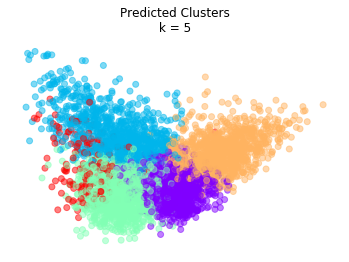

In [112]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 5 ')
plt.show()

    Seeing from the graph, it seems that k=4 is probably a more reasonable number, as it looks like these points can be naturally separated into 4 different clusters in the vector space. Nonetheless, we will use silhouette method to try to determine an optimal k.

In [113]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


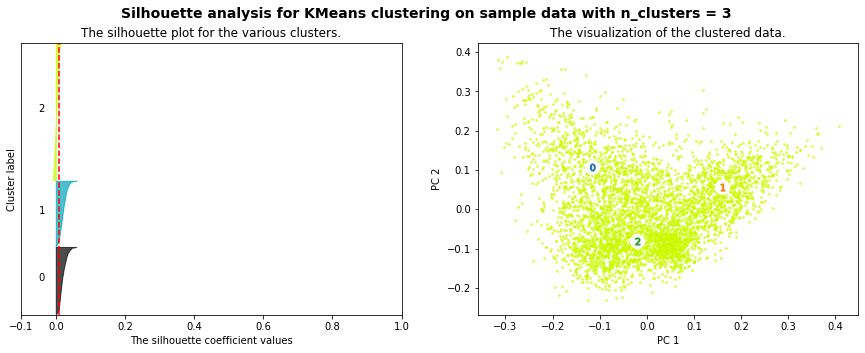

For n_clusters = 3, The average silhouette_score is : 0.011


In [114]:
X = abstractTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


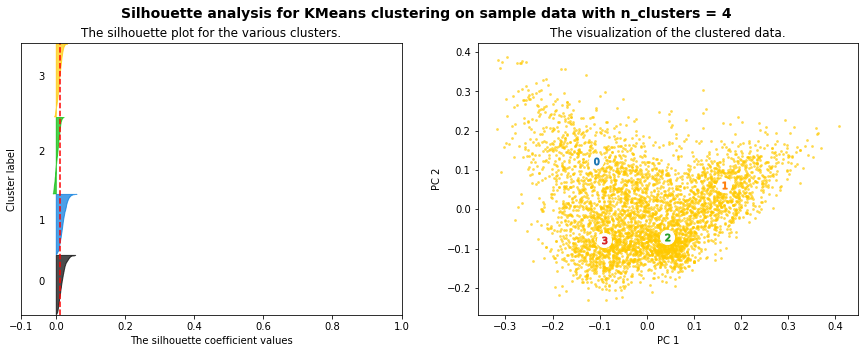

For n_clusters = 4, The average silhouette_score is : 0.012


In [115]:
X = abstractTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


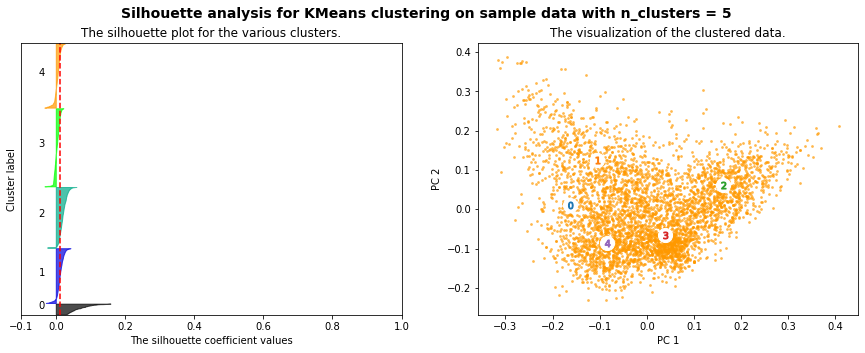

For n_clusters = 5, The average silhouette_score is : 0.011


In [116]:
X = abstractTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


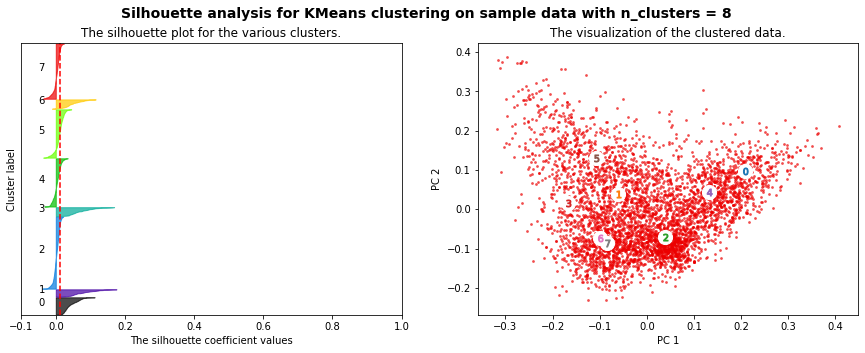

For n_clusters = 8, The average silhouette_score is : 0.012


In [117]:
X = abstractTFVects.toarray()
plotSilhouette(8, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


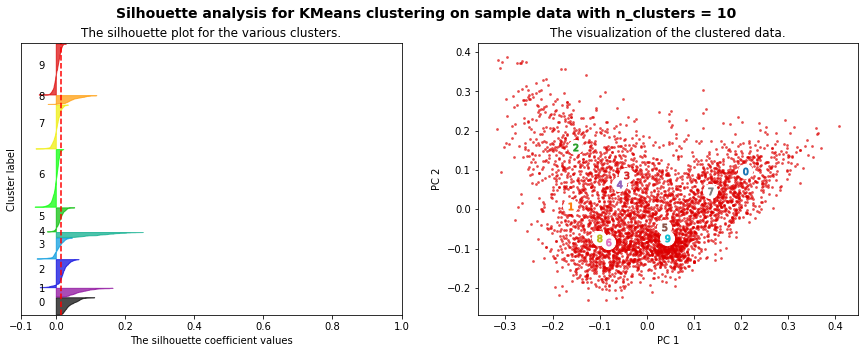

For n_clusters = 10, The average silhouette_score is : 0.014


In [118]:
X = abstractTFVects.toarray()
plotSilhouette(10, X)

    This is really interesting. We see that using the silhouette method, k=10 performed better than all the other ks. It is possible that the data actually a lot of different topics. Let's see what k=10 looks like:

In [ ]:
km10 = sklearn.cluster.KMeans(n_clusters=10, init='k-means++')
km10.fit(abstractTFVects)

terms10 = ngTFVectorizer.get_feature_names()

In [120]:
print("Top terms per cluster:")
order_centroids = km10.cluster_centers_.argsort()[:, ::-1]
for i in range(10):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms10[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 mice
 brain
 expression
 neurons
 induced
 neuronal
 protein
 rats
 effects
 activity


Cluster 1:
 patients
 treatment
 clinical
 study
 group
 disease
 patient
 years
 surgery
 care


Cluster 2:
 health
 social
 children
 care
 study
 risk
 self
 use
 psychological
 research


Cluster 3:
 ci
 95
 risk
 associated
 patients
 odds
 study
 use
 health
 studies


Cluster 4:
 cells
 cell
 expression
 cancer
 mir
 stem
 proliferation
 differentiation
 human
 tumor


Cluster 5:
 behavior
 model
 based
 properties
 using
 different
 high
 water
 method
 used


Cluster 6:
 ad
 tau
 aβ
 disease
 alzheimer
 amyloid
 dementia
 mice
 neurodegenerative
 protein


Cluster 7:
 cognitive
 brain
 task
 visual
 performance
 memory
 connectivity
 functional
 processing
 participants


Cluster 8:
 pain
 sleep
 chronic
 patients
 quality
 treatment
 effects
 related
 nerve
 review


Cluster 9:
 patient
 case
 surgery
 treatment
 cases
 tumor
 clinical
 surgical
 year
 an

        The clusters presented in k=10 exhibit some really interesting pattern. For example, we see in cluster 6, key words associated with alzheimer like tau, beta amyloid, dementia, and neurodegenerative are included in the cluster. This is basically an Alzheimer cluster that wasn't detected in k=5. Also, cluster 4 seems to be dedicated to cancer, which was also not explicitly identified in k=5.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

    Let's take country as our target label in this exercise.

    First, we'll take the matrix of word counts per abstract `abstractTFVects` and create a word occurrence matrix measuring how similar the abstracts are to each other based on their number of shared words. 

In [121]:
abstractTFVects.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.06173592, 0.0674585 , 0.12128678, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.17477838, 0.09300312,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [124]:
abstractCoocMat = abstractTFVects * abstractTFVects.T
abstractCoocMat.setdiag(0) #don't care about abstract's similarity with self

In [128]:
selectIndices = []
indexToCat = []
for c in set(psyc['country']):
    selectIndices += list(psyc[psyc['country'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [130]:
subCoocMat = abstractCoocMat[selectIndices,:][:,selectIndices]

In [131]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

//anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[375.        , 376.        ,   0.94948731,   2.        ],
       [239.        , 286.        ,   0.96010099,   2.        ],
       [279.        , 591.        ,   0.97845489,   2.        ],
       [254.        , 289.        ,   1.008256  ,   2.        ],
       [256.        , 724.        ,   1.01813261,   2.        ],
       [ 70.        , 479.        ,   1.02446148,   2.        ],
       [702.        , 830.        ,   1.03349591,   3.        ],
       [  0.        , 322.        ,   1.05564561,   2.        ],
       [234.        , 590.        ,   1.05805004,   2.        ],
       [ 47.        , 835.        ,   1.06067736,   3.        ]])

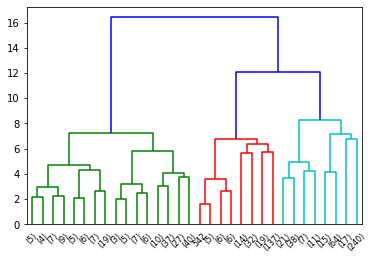

In [132]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [136]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 1, 2, 2, 2, 2, 2, 2, 4, 1, 4, 2, 2, 3, 1, 4, 4, 4, 1, 4, 1, 1,
       4, 3, 3, 2, 4, 4, 4, 2, 2, 4, 1, 1, 1, 2, 1, 2, 2, 4, 4, 1, 4, 4,
       4, 1, 2, 4, 4, 4, 1, 4, 2, 2, 2, 2, 3, 4, 4, 4, 2, 1, 1, 2, 1, 1,
       4, 4, 4, 2, 4, 3, 1, 2, 2, 1, 1, 3, 2, 1, 2, 2, 2, 4, 2, 1, 1, 1,
       3, 3, 4, 3, 3, 3, 1, 3, 4, 1, 2, 1, 2, 1, 1, 1, 2, 3, 1, 2, 2, 2,
       1, 1, 1, 2, 4, 4, 1, 1, 1, 4, 2, 4, 2, 2, 2, 2, 2, 4, 1, 1, 2, 2,
       2, 4, 4, 2, 4, 4, 1, 1, 1, 1, 4, 3, 2, 1, 2, 3, 1, 2, 3, 4, 4, 2,
       1, 4, 4, 2, 2, 3, 1, 2, 4, 1, 1, 4, 4, 1, 4, 4, 1, 1, 1, 4, 4, 2,
       2, 4, 2, 4, 1, 1, 2, 4, 1, 1, 4, 1, 4, 2, 1, 1, 1, 1, 2, 4, 4, 3,
       4, 4, 1, 2, 1, 4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 2, 1, 4, 2, 4, 4, 2,
       1, 1, 2, 4, 4, 1, 4, 4, 2, 1, 4, 4, 1, 1, 4, 4, 2, 3, 2, 2, 2, 2,
       3, 4, 4, 1, 2, 4, 4, 1, 3, 4, 2, 4, 4, 2, 2, 1, 4, 4, 4, 4, 1, 3,
       2, 3, 4, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 2, 4, 4, 1, 2, 4, 4, 4,
       2, 4, 2, 4, 2, 4, 4, 2, 4, 4, 2, 4, 4, 3, 4,

In [138]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(abstractCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(psyc['country'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(psyc['country'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(psyc['country'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(psyc['country'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.026
Completeness: 0.039
V-measure: 0.031
Adjusted Rand Score: 0.003


    We see that Wald doesn't perform very well. This is entirely reasonable because our label, 'country' is really hard to predict. Intuitively, countries should be performing similar researches. Moreover, the majority pubmed data are actually US publications, therefore the training data is extremely imbalanced.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [141]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

psyc['reduced_token'] = psyc['abstract_norm'].apply(lambda x: dropMissing(x, ngTFVectorizer.vocabulary_.keys()))

In [164]:
dictionary = gensim.corpora.Dictionary(psyc['reduced_token'])

In [165]:
corpus = [dictionary.doc2bow(text) for text in psyc['reduced_token']]

In [167]:
gensim.corpora.MmCorpus.serialize('abstract.mm', corpus)
abstractmm = gensim.corpora.MmCorpus('abstract.mm')

In [168]:
#because we saw using silouette method that k=10 actually works the best among all ks
#we will set num_topics=10
abstract_lda = gensim.models.ldamodel.LdaModel(corpus=abstractmm, 
                                               id2word=dictionary, num_topics=10, 
                                               alpha='auto', eta='auto')

In [170]:
ldaDF = pd.DataFrame({'name' : psyc['title'],
                      'topics' : [abstract_lda[dictionary.doc2bow(l)] for l in psyc['reduced_token']]})

In [175]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(abstract_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(abstract_lda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [176]:
ldaDF.head(5)

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,Is Performing Repetitions to Failure Less Impo...,"[(4, 0.98012775)]",0.000000,0.0,0.000000,0.0,0.980128,0.000000,0.000000,0.000000,0.0,0.000000
1,"Correlation of Eccentric Strength, Reactive St...","[(6, 0.26244828), (7, 0.7187573)]",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.262448,0.718757,0.0,0.000000
2,Effectiveness of Surgical Treatment for Degene...,"[(2, 0.47253013), (5, 0.2904577), (9, 0.227093...",0.000000,0.0,0.472530,0.0,0.000000,0.290458,0.000000,0.000000,0.0,0.227093
3,A Deep Convolutional Neural Network with Perfo...,"[(0, 0.2269015), (2, 0.5427457), (9, 0.2158666)]",0.226902,0.0,0.542746,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.215867
4,Function Preservation or Oncological Appropria...,"[(0, 0.10212699), (2, 0.23635516), (4, 0.30007...",0.102127,0.0,0.236355,0.0,0.300078,0.354569,0.000000,0.000000,0.0,0.000000


In [177]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.0,0.000000,0.000000,0.980128,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.262448,0.718757,0.000000,0.000000
2,0.000000,0.0,0.472530,0.000000,0.000000,0.290458,0.000000,0.000000,0.000000,0.227093
3,0.226902,0.0,0.542746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.215867
4,0.102127,0.0,0.236355,0.000000,0.300078,0.354569,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.0,0.729438,0.142476,0.000000,0.117543,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.0,0.324407,0.000000,0.012414,0.653692,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.0,0.533114,0.097740,0.000000,0.359266,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.0,0.814431,0.000000,0.000000,0.000000,0.104823,0.000000,0.070274,0.000000
9,0.642839,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066462,0.275109


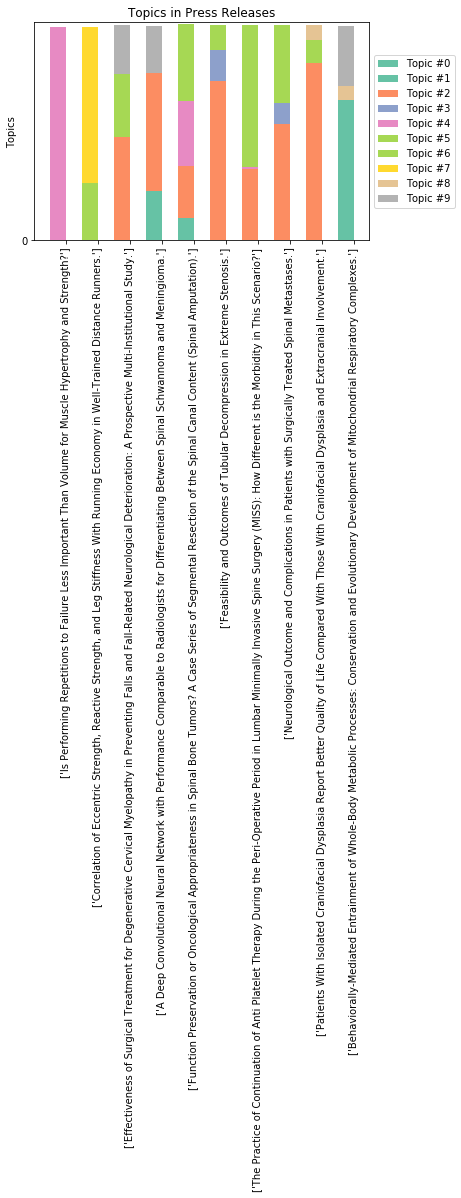

In [205]:
N = 10
ind = np.arange(N)
K = abstract_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.Set2(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5));

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  del sys.path[0]


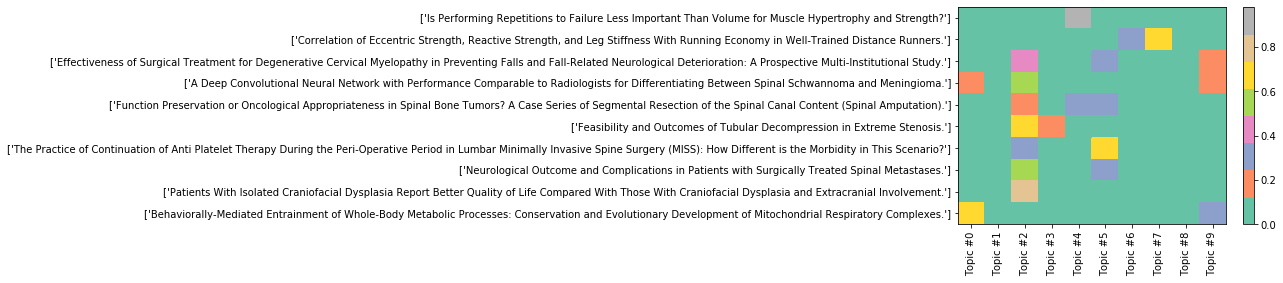

In [204]:
plt.pcolor(ldaDFVis, norm=None, cmap='Set2')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

    We see that each of these articles seem to only belong to a few topics extracted. Let's see the topics and  combine the results together.

In [188]:
for i in range(10):
    print('Terms with the highest LDA weights in topic {}'.format(i))
    print(abstract_lda.show_topic(i), '\n')

Terms with the highest LDA weights in topic 0
[('neuron', 0.04191029), ('cell', 0.037660282), ('ad', 0.0266818), ('mice', 0.026464283), ('protein', 0.024955265), ('gene', 0.022253575), ('level', 0.021613505), ('brain', 0.020839883), ('result', 0.019814251), ('effect', 0.018225437)] 

Terms with the highest LDA weights in topic 1
[('children', 0.04311532), ('symptom', 0.040390078), ('behavior', 0.035825033), ('sleep', 0.035583522), ('use', 0.032507494), ('child', 0.025150556), ('assess', 0.02329623), ('result', 0.019589547), ('age', 0.017035928), ('rate', 0.01563816)] 

Terms with the highest LDA weights in topic 2
[('patient', 0.13645387), ('treatment', 0.024082538), ('method', 0.021548713), ('result', 0.020607764), ('use', 0.02013263), ('aneurysm', 0.019521507), ('report', 0.014257613), ('present', 0.0129754385), ('predict', 0.012806576), ('case', 0.012294426)] 

Terms with the highest LDA weights in topic 3
[('model', 0.069971725), ('pain', 0.04894165), ('effect', 0.033713467), ('use

        We see several words such as 'use', 'result', 'effect', 'patient' appear multiple times in different topics. We also see words such as 'research', 'function', 'control', 'method', 'review' that are weighted as important by LDA, but are actually not very meaningful in distinguishing a topic from another in real world. In my final research, I will examine the tokenized words visually, and I intend to remove some of these less meaningful yet frequently appearing words manually. For this assignment, we will leave these words be for now.
        Although we see repetitive words appearing across topics, we can still distinguish some subtle differences between the topics extracted. For example, we see that  topic 0 is closely related with neuroscience concepts, and that topic 1 is related to less biological topics such as sleep and child.

<Figure size 432x288 with 0 Axes>

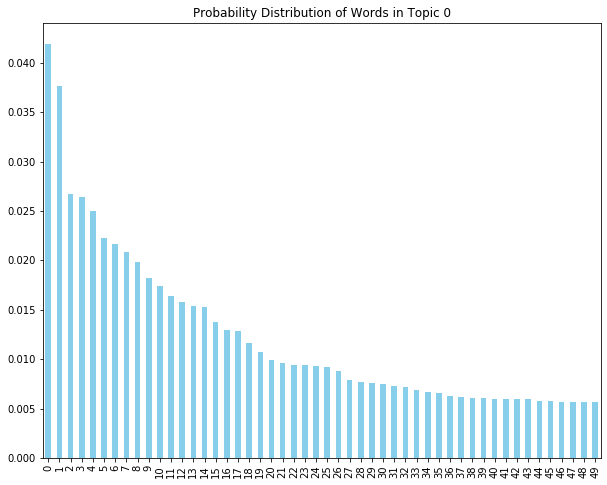

In [213]:
topic0_df = pd.DataFrame(abstract_lda.show_topic(0, topn=50))
plt.figure()
topic0_df.plot.bar(legend = False, figsize=(10,8), color='skyblue')
plt.title('Probability Distribution of Words in Topic 0');

In [193]:
#check how different eta values can change the shape of the distribution.

In [207]:
abstract1 = gensim.models.ldamodel.LdaModel(corpus=abstractmm, id2word=dictionary, num_topics=10, eta = 0.00001)
abstract2 = gensim.models.ldamodel.LdaModel(corpus=abstractmm, id2word=dictionary, num_topics=10, eta = 0.9)

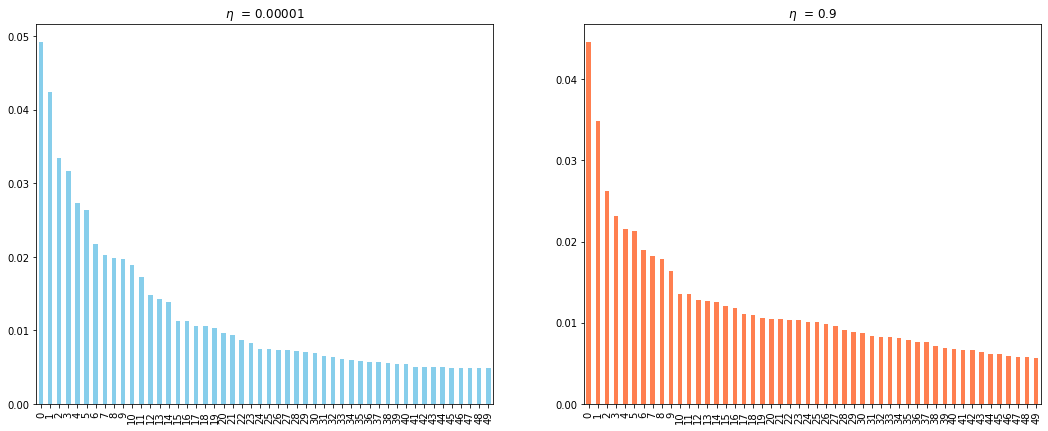

In [215]:
topic_e0_df = pd.DataFrame(abstract1.show_topic(0, topn=50))
topic_e1_df = pd.DataFrame(abstract2.show_topic(0, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic_e0_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001', color='skyblue')
topic_e1_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9', color='coral');

    We don't see a huge difference in probability distribution with different eta values.

In [218]:
abstract3 = gensim.models.ldamodel.LdaModel(corpus=abstractmm, id2word=dictionary, num_topics=5, eta = 0.9)
abstract4 = gensim.models.ldamodel.LdaModel(corpus=abstractmm, id2word=dictionary, num_topics=10, eta = 0.9)

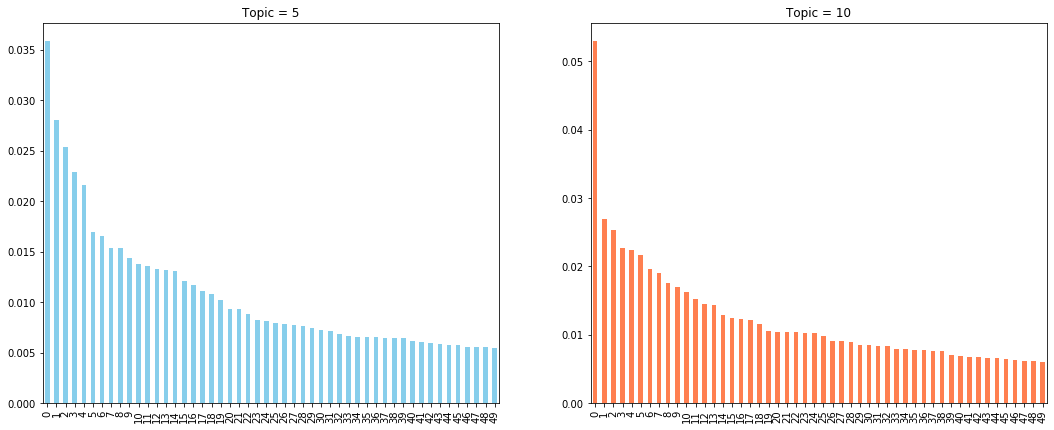

In [220]:
topic5_df = pd.DataFrame(abstract3.show_topic(0, topn=50))
topic10_df = pd.DataFrame(abstract4.show_topic(0, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic5_df.plot.bar(legend = False, ax = ax1, title = 'Topic = 5', color='skyblue')
topic10_df.plot.bar(legend = False, ax = ax2, title = 'Topic = 10', color='coral');

    We see that when topic=10, the top weighted term in the first topic is more 'significant' when compared with the top weighted term in the first topic in topic=5.  



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

    Kung Fu Panda's script was downloaded for this exercise. 

In [409]:
kungfu = pd.read_csv("./kung-fu-panda/KFP2Script.csv")
kungfu.columns=['script']
kungfu.dropna(inplace=True)

In [414]:
text = ' '.join(kungfu['script'][0:2000]).split()

In [416]:
#check what characters are in there
names = set()
for word in text:
    if word.isupper():
        names.add(word)

In [417]:
print(names)

{'SHIFU:', 'FURIOUS', 'AAAAAAAAAAHHH!!!', 'SET', 'BUNNY:', 'SOOTHSAYER:', 'KABOOM!', 'CRANE:', 'I?', 'RHINO:', 'SURRENDER!', 'NO!', 'KEEP', 'CUTE?!', 'BUNNY', 'SAID', 'FEMALE', '[WHACK!', 'AT', 'GUUUUUYS!', 'GORILLA:', 'WOLF:', 'PIG:', 'ANTELOPE:', 'VIPER:', 'PO:', 'NOOO!', 'FIRING!', 'KNOW!', 'MOTHER', '3D', 'THEM!', 'MONKEY:', 'FIRE!', '...I', 'VIPER,', 'ALAKASQUASH-O!', 'I...', '[A', 'CHILD:', 'MR.', 'YOU', 'MANTIS', 'SAIL!', 'NOW!', 'BOSS:', '[BOOM!', 'LOVE', 'PIG', 'BUG!', 'INNER', 'WOLVES:', '2D', 'YAH!', 'AAAAAAAAAAAAAAAAAAAAAAAAAGHHHHH!', 'FIVE:', 'BOSS', '(SOOTHSAYER):', 'FEAR', 'NARRATOR', 'MANTIS:', 'OX:', 'PRISONER:', 'OX', 'FIRE', 'POW!', "PO'S", 'TIGRESS:', 'CROC:', '(CROC:', 'BUNNIES:', '[CRASH!', 'WAAAAAH!', 'THIS!', 'MONKEY,', 'KID:', 'COWARD!', 'FIVE', "DON'T", 'BOAR', 'WE', 'A', 'MOTHER:', 'I--', 'CRANE', 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGHHHHHHHHH!', 'COSTUMER:', 'BOOM!', 'NARRATOR:', 'KA-KAW!', 'SHEN:', 'CRANE,', 'RHINO,', 'SHEEP:', 'FATHER:', '

In [475]:
chars = ['PO', 'SHIFU', 'SOOTHSAYER','BOSS', 'TIGRESS','RHINO','WOLVES','VIPER', 'MONKEY', 'MANTIS', 'CROC']

In [476]:
kungfu['tokenized_sents'] = kungfu['script'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
#kungfu['normalized_sents'] = kungfu['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [477]:
#kungfu = kungfu.reset_index()
kungfu['tokenized_sents'].head(5)

0                                [[Film, title, card]]
1    [[Written, here, is, the, full, transcript, of...
3    [[Opens, up, to, a, narrated, story, displayed...
4    [[NARRATOR, SOOTHSAYER], [In, voiceover, Long,...
6    [[Puppet, citizens, gather, in, the, streets, ...
Name: tokenized_sents, dtype: object

In [478]:
kungfu_script = []

for each in kungfu['tokenized_sents']:
    for sent in each:
        for word in sent:
            kungfu_script.append(word)
        

In [479]:
print(kungfu_script[0:200])

['Film', 'title', 'card', 'Written', 'here', 'is', 'the', 'full', 'transcript', 'of', 'DreamWorks', 'Animation', "'s", 'full', 'length', 'feature', 'film', 'and', 'sequel', 'Kung', 'Fu', 'Panda', '2', 'Opens', 'up', 'to', 'a', 'narrated', 'story', 'displayed', 'in', 'a', '2D', 'animated', 'shadow', 'puppet', 'show', 'Two', 'peacocks', 'overlook', 'a', 'tall', 'majestic', 'tower', 'NARRATOR', 'SOOTHSAYER', 'In', 'voiceover', 'Long', 'ago', 'in', 'ancient', 'China', 'the', 'peacocks', 'ruled', 'over', 'Gongmen', 'City', 'They', 'brought', 'great', 'joy', 'and', 'prosperity', 'to', 'the', 'city', 'for', 'they', 'had', 'invented', 'fireworks', 'Puppet', 'citizens', 'gather', 'in', 'the', 'streets', 'as', 'colorful', 'fireworks', 'explode', 'over', 'the', 'city', 'The', 'scene', 'then', 'changes', 'to', 'a', 'room', 'in', 'the', 'palace', 'a', 'young', 'white', 'peacock', 'experiments', 'with', 'the', 'gunpowder', 'A', 'small', 'explosion', 'from', 'the', 'bowl', 'surprises', 'him', 'and', 

In [480]:
#count each character's lines
character_lines = {}
for token in kungfu_script:
    if token in chars:
        if token not in character_lines:
            character_lines[token] = 0
        if token in character_lines:
            character_lines[token] += 1
character_lines

{'SOOTHSAYER': 36,
 'BOSS': 35,
 'MANTIS': 24,
 'TIGRESS': 69,
 'PO': 209,
 'MONKEY': 13,
 'SHIFU': 14,
 'VIPER': 19,
 'RHINO': 4,
 'CROC': 9,
 'WOLVES': 1}

In [481]:
#create graph
char_network = nx.Graph()

In [482]:
chars

['PO',
 'SHIFU',
 'SOOTHSAYER',
 'BOSS',
 'TIGRESS',
 'RHINO',
 'WOLVES',
 'VIPER',
 'MONKEY',
 'MANTIS',
 'CROC']

In [483]:
for character in character_lines:
        char_network.add_node(character, lines_spoken= character_lines[character], words=[])

In [484]:
i = 0
final = []
for token in kungfu_script:
    i += 1
    if i > len(kungfu_script):
        break
    
    if token in char_network.nodes():
        j = i
        for token_ in kungfu_script[i:]:
            if token_ in char_network.nodes():
                # if both the characters exist in the graph, add a weight
                if token_ != token:
                    if (token, token_) not in char_network.edges():
                        char_network.add_edge(token, token_, weight=0)
                    if (token, token_) in char_network.edges():
                        char_network.edges[(token, token_)]['weight'] += 1
                break
            j += 1
        # adding characters sentences
        char_network.nodes[token]['words'].append(kungfu_script[i:j])
        final.append(lucem_illud_2020.normalizeTokens(kungfu_script[i:j]))

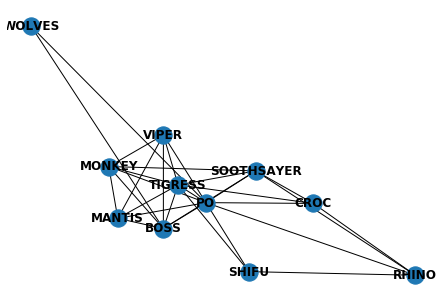

In [485]:
nx.draw(char_network, with_labels=True, font_weight='bold')

    We see from the above graph that PO is near the center, connecting every character together, with his friends surrounding him. Let's create a topic model with all the texts spoken by each character to understand their interactions better.

In [486]:
dictionary = gensim.corpora.Dictionary(final)
corpus = [dictionary.doc2bow(text) for text in final]
gensim.corpora.MmCorpus.serialize('kungfu.mm', corpus)
kfcorpus = gensim.corpora.MmCorpus('kungfu.mm')
kungfulda = gensim.models.ldamodel.LdaModel(corpus=kfcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [487]:
kungfulda.show_topics()

[(0,
  '0.028*"shen" + 0.026*"po" + 0.011*"wolf" + 0.010*"look" + 0.009*"cannon" + 0.008*"let" + 0.008*"guy" + 0.008*"walk" + 0.008*"ho" + 0.007*"soothsayer"'),
 (1,
  '0.039*"po" + 0.038*"wolf" + 0.030*"shen" + 0.009*"tigress" + 0.008*"boss" + 0.008*"mr" + 0.007*"ping" + 0.007*"look" + 0.007*"cannon" + 0.006*"costume"'),
 (2,
  '0.022*"wolf" + 0.018*"shen" + 0.014*"know" + 0.012*"po" + 0.012*"mr" + 0.012*"ping" + 0.009*"look" + 0.009*"jail" + 0.007*"master" + 0.007*"son"'),
 (3,
  '0.028*"ping" + 0.027*"mr" + 0.018*"po" + 0.015*"shen" + 0.010*"know" + 0.007*"yes" + 0.007*"pig" + 0.007*"get" + 0.007*"think" + 0.006*"inner"'),
 (4,
  '0.028*"shen" + 0.026*"po" + 0.016*"wolf" + 0.013*"eye" + 0.010*"panda" + 0.008*"city" + 0.007*"radish" + 0.007*"like" + 0.007*"soothsayer" + 0.007*"stare"'),
 (5,
  '0.035*"shen" + 0.024*"po" + 0.024*"wolf" + 0.011*"tigress" + 0.009*"leap" + 0.009*"warrior" + 0.009*"mr" + 0.009*"yes" + 0.009*"ox" + 0.008*"ping"'),
 (6,
  '0.071*"po" + 0.024*"shen" + 0.015*

In [488]:
for char in char_network.nodes():
    char_all_words = []
    for sent in char_network.nodes[char]['words']:
        for word in sent:
            char_all_words += word
    char_network.nodes[char]['topic_distribution'] = kungfulda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(char_all_words))]

In [489]:
for char in char_network.nodes():
    print(char, char_network.nodes[char]['topic_distribution'])

SOOTHSAYER [(1, 0.49136087), (6, 0.5083688)]
BOSS [(1, 0.5123572), (6, 0.48723045)]
MANTIS [(1, 0.49558815), (6, 0.5036933)]
TIGRESS [(1, 0.49184522), (6, 0.50787467)]
PO [(1, 0.4851603), (6, 0.51477724)]
MONKEY [(1, 0.43097404), (6, 0.56723595)]
SHIFU [(1, 0.512812), (6, 0.48588336)]
VIPER [(1, 0.46363595), (6, 0.5347522)]
RHINO [(1, 0.5386557), (6, 0.45913038)]
CROC [(1, 0.42897838), (6, 0.5687391)]
WOLVES [(1, 0.47648656), (6, 0.50903845)]


In [490]:
from gensim.matutils import kullback_leibler

In [491]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [492]:
char_network.nodes

NodeView(('SOOTHSAYER', 'BOSS', 'MANTIS', 'TIGRESS', 'PO', 'MONKEY', 'SHIFU', 'VIPER', 'RHINO', 'CROC', 'WOLVES'))

In [494]:
L = []
for char_1 in char_network.nodes():
    p = char_network.nodes[char_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for char_2 in char_network.nodes():
        q = char_network.nodes[char_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

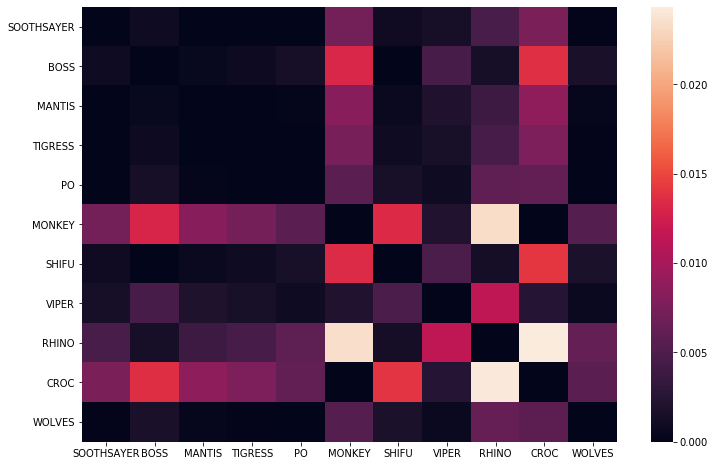

In [503]:
fig = plt.figure(figsize=(12,8))
div = pd.DataFrame(M, columns = list(char_network.nodes()), index = list(char_network.nodes()))
ax = sns.heatmap(div)

    It is interesting to see that SHIFU, SOOTHSAYER, MANTIS, TIGRESS, PO and WOLVES talk very similarly with one another. Maybe this is saying that those with Kungfu talk similarly in the film? However, two interesting outliers of this theory are Monkey and the Viper. They belong to the Kungfu gang, but they don't seem to speak their language. 